This notebook is mainly for messing around with Geopandas objects and figuring out what the best way is to plan a path\
To run this code, you need to install shapely, geopandas matplotlib and numpy 

In [1]:
import json
import matplotlib.pyplot as plt

from shapely.geometry import Polygon
from shapely.geometry import LineString
import geopandas as gpd
import numpy as np

In [2]:
# This cell opens the json file that contains field geometry
with open("./data/field_geometry/test_1.json") as json_file:
    json_data = json.load(json_file) # or geojson.load(json_file)

In [3]:
# This cell parses the json data and obtains a list with the coordinates for each polygon like
# [[polygon1_coords],[polygon2_coords],....]
# where polygon1_coords looks something like this: [[x1,y1],[x2,y2],......]
coordinates = []
for i in range(len(json_data['features'])):
    coordinates.append(json_data['features'][i]['geometry']['coordinates'])

In [4]:
# Here we create a geoseries object from the polygons 
polygon1 = gpd.GeoSeries(Polygon(coordinates[1][0]))
hole = gpd.GeoSeries(Polygon(coordinates[2][0]))
# Creating a buffer with a specific size (in this case 1)
obstacle_buffer = hole.buffer(1)
polygon1_buffer = polygon1.buffer(-1)

In [5]:
# Here we substract the hole from the field, the first line does this for the field and hole without headlands, the second line does it
# for field and hole with headlands

field = polygon1.symmetric_difference(hole)

field_with_headlands = polygon1_buffer.symmetric_difference(obstacle_buffer)

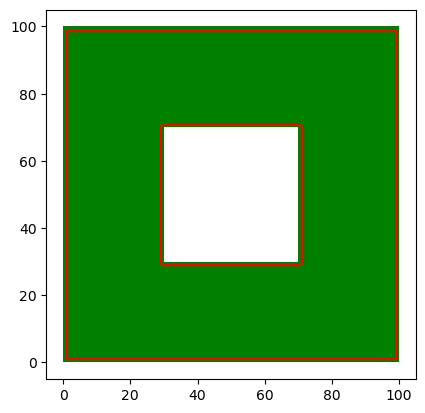

In [6]:
# Plotting the field (green) and headland boundaries
fig, ax = plt.subplots()
field.plot(ax = ax, color = 'green')
field_with_headlands.boundary.plot(ax = ax,color = 'red')
plt.show()

In [7]:
# An easy way to obtain x and y coordinates for a polygon or polyline
polygon1.get_coordinates()

,x,y
0,0.0,0.0
0,0.0,100.0
0,100.0,100.0
0,100.0,0.0
0,0.0,0.0


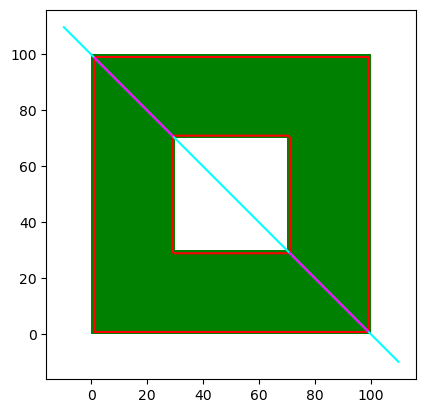

In [8]:
# Creating straight lines as vectors and clipping them to the field boundaries
vector = [[-10,110],[110,-10]]
# Here we make another geoseries object from the vector
swath = gpd.GeoSeries(LineString(vector))
# and we clip the vector so that it only covers the field and does not cross over into the headlands
swath_clipped = gpd.clip(swath,field_with_headlands)


# Plotting the original swath (cyan) and the clipped one (magenta)

fig, ax = plt.subplots()
field.plot(ax = ax, color = 'green')
field_with_headlands.boundary.plot(ax = ax,color = 'red')
swath.plot(ax = ax,color = 'cyan', marker = '+')
swath_clipped.plot(ax = ax, color = 'magenta')
plt.show()

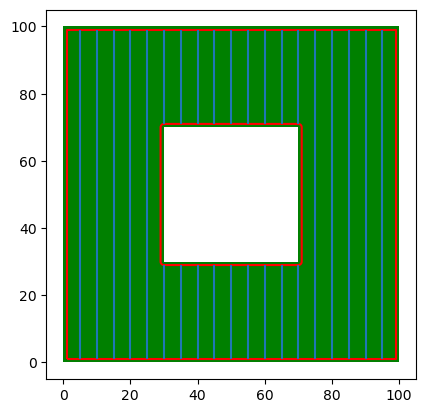

1484.0


In [19]:

# This cell combines the above cells and creates a bunch of parallel vectors with a fixed distance, clips them to the 
# boundaries of the field and then calculates the total length of the path

vector = []
for i in range(100):
    vector.append([[0+i*5,100],[0+i*5,0]])

swaths = []
swaths_clipped = []
for i in range(len(vector)):
    swaths.append(gpd.GeoSeries(LineString(vector[i])))
    swaths_clipped.append(gpd.clip(swaths[i],field_with_headlands))

fig, ax = plt.subplots()
field.plot(ax = ax, color = 'green')
field_with_headlands.boundary.plot(ax = ax,color = 'red')
total_swath_length = 0
for i in range(len(swaths_clipped)):
    if not swaths_clipped[i].get_coordinates().empty: # This line is to make sure we don't calculate the length for vectors that are completely outside of the boundaries
        swaths_clipped[i].plot(ax = ax)
        total_swath_length+=swaths_clipped[i][0].length

plt.show()
print(total_swath_length)

In [15]:
# import numpy as np

def rotate_vector_z(vector, theta_z):
    # Convert angle to radians
    theta_z = np.radians(theta_z)

    # 2D Rotation matrix around the z-axis
    R_z = np.array([[np.cos(theta_z), -np.sin(theta_z)],
                    [np.sin(theta_z), np.cos(theta_z)]])

    # Rotate the vector
    rotated_vector = np.dot(R_z, vector)

    return rotated_vector

# Example usage
vector = np.array([1, 0])  # Example vector along the x-axis
theta_z = 45  # Rotation angle in degrees around z-axis

rotated_vector = rotate_vector_z(vector, theta_z)
print("Original Vector:", vector)
print("Rotated Vector around Z-axis:",rotated_vector)

Original Vector: [1 0]
Rotated Vector around Z-axis: [0.70710678 0.70710678]


In [90]:
# Example usage
vector = np.array([10000, 0])  # Example vector along the x-axis
for theta_z in range(0,95,5):
    # theta_z = 45  # Rotation angle in degrees around z-axis
    d = 10
    dx = d/(np.sin(np.radians(theta_z))+0.01)
    rotated_vector = rotate_vector_z(vector, theta_z)
    rotated_vector = [[0,0],list(rotated_vector)]
    vector_list = []
    for i in range(-10,10):
        vector_list.append([[rotated_vector[0][0]+i*dx,rotated_vector[0][1]],[rotated_vector[1][0]+dx*i,rotated_vector[1][1]]])



    swaths = []
    swaths_clipped = []
    for i in range(len(vector_list)):
        swaths.append(gpd.GeoSeries(LineString(vector_list[i])))
        swaths_clipped.append(gpd.clip(swaths[i],field_with_headlands))

    # fig, ax = plt.subplots()
    # field.plot(ax = ax, color = 'green')
    # field_with_headlands.boundary.plot(ax = ax,color = 'red')
    total_swath_length = 0
    for i in range(len(swaths_clipped)):
        if not swaths_clipped[i].get_coordinates().empty: # This line is to make sure we don't calculate the length for vectors that are completely outside of the boundaries
            # swaths_clipped[i].plot(ax = ax)
            total_swath_length+=swaths_clipped[i][0].length

    # plt.show()
    
    print('Theta: {:6f}, total_length: {:6f}'.format(theta_z,total_swath_length))



Theta: 0.000000, total_length: 0.000000
Theta: 5.000000, total_length: 860.948812
Theta: 10.000000, total_length: 831.740609
Theta: 15.000000, total_length: 816.633977
Theta: 20.000000, total_length: 813.056012
Theta: 25.000000, total_length: 804.817470
Theta: 30.000000, total_length: 800.732728
Theta: 35.000000, total_length: 798.668438
Theta: 40.000000, total_length: 797.552416
Theta: 45.000000, total_length: 796.682440
Theta: 50.000000, total_length: 795.625354
Theta: 55.000000, total_length: 794.563742
Theta: 60.000000, total_length: 794.564152
Theta: 65.000000, total_length: 793.030607
Theta: 70.000000, total_length: 797.975278
Theta: 75.000000, total_length: 798.882329
Theta: 80.000000, total_length: 794.944562
Theta: 85.000000, total_length: 804.631815
Theta: 90.000000, total_length: 672.090946


Theta: 5.000000, total_length: 860.948812


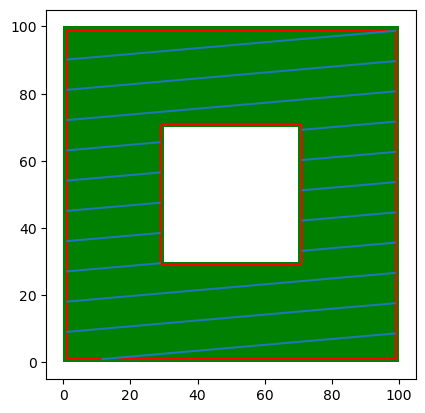

In [91]:
d = 10
theta_z = 5  # Rotation angle in degrees around z-axis
dx = d/(np.sin(np.radians(theta_z))+0.01)
# dx = d
vector = np.array([10000, 0])
rotated_vector = rotate_vector_z(vector, theta_z)
rotated_vector = [[0,0],list(rotated_vector)]
vector_list = []
for i in range(-20,20):
    vector_list.append([[rotated_vector[0][0]+i*dx,rotated_vector[0][1]],[rotated_vector[1][0]+dx*i,rotated_vector[1][1]]])



swaths = []
swaths_clipped = []
for i in range(len(vector_list)):
    swaths.append(gpd.GeoSeries(LineString(vector_list[i])))
    swaths_clipped.append(gpd.clip(swaths[i],field_with_headlands))

fig, ax = plt.subplots()
field.plot(ax = ax, color = 'green')
field_with_headlands.boundary.plot(ax = ax,color = 'red')
total_swath_length = 0
for i in range(len(swaths_clipped)):
    if not swaths_clipped[i].get_coordinates().empty: # This line is to make sure we don't calculate the length for vectors that are completely outside of the boundaries
        swaths_clipped[i].plot(ax = ax)
        total_swath_length+=swaths_clipped[i][0].length
print('Theta: {:6f}, total_length: {:6f}'.format(theta_z,total_swath_length))

plt.show()

In [69]:
10/np.sin(np.radians(10))

10.15426611885745